# Normal breast epithelia comprise three major populations plus transient intermediates

This notebook attempts to reproduce the analysis done to arrive at the source papers first result, normal breast tissue contains three major types of cells: basal, luminal progenitor, and mature luminal.

This analysis was performed on the single-cell RNA sequencing data for 11 subjects, corresponding to the following identifiers:
|"Sample" identifier|File identifier|
|---|---|
|N-1105-epi|`GSM4909260_N-N1105-Epi`|
|N-0280-epi|`GSM4909255_N-N280-Epi`|
|N-0230.16-epi|`GSM4909264_N-N1B-Epi`|
|N-0408-epi|`GSM4909259_N-NE-Epi`|
|N-1469-epi|`GSM4909258_N-NF-Epi`|
|N-0123-epi|`GSM4909267_N-MH0023-Epi`|
|N-0064-epi|`GSM4909313_N-MH0064-Epi`|
|N-0093-epi|`GSM4909256_N-PM0095-Epi`|
|N-0342-epi|`GSM4909269_N-PM0342-Epi`|
|N-0372-epi|`GSM4909275_N-PM0372-Epi`|
|N-0275-epi|`GSM4909273_N-MH275-Epi`|

This table was arrived at through:
* Figure 1c in the source article lists the "Sample" (quotes to emphasize in the context of the article, a sample is analogous to a human subject) identifiers used.
* Supplementary table 1 of the source article maps identifiers to file identifiers.

## 0. Initializations

In [1]:
# -- imports --
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from signals_in_the_noise.preprocessing.gse161529 import GSE161529
from signals_in_the_noise.utilities.storage import get_resources_path
from signals_in_the_noise.utilities.visualization import get_figure_axes

In [2]:
# -- datasets --
filenames = [
    "GSM4909255_N-N280-Epi.h5ad",
    "GSM4909256_N-PM0095-Epi.h5ad",
    "GSM4909258_N-NF-Epi.h5ad",
    "GSM4909259_N-NE-Epi.h5ad",
    "GSM4909260_N-N1105-Epi.h5ad",
    "GSM4909262_N-MH0064-Epi.h5ad",
    "GSM4909264_N-N1B-Epi.h5ad",
    "GSM4909267_N-MH0023-Epi.h5ad",
    "GSM4909269_N-PM0342-Epi.h5ad",
    "GSM4909273_N-MH275-Epi.h5ad",
    "GSM4909275_N-PM0372-Epi.h5ad",
]
gse = GSE161529()

2025-07-11 20:18:25,250 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909253_N-PM0092-Total.h5ad as AnnData object.
2025-07-11 20:18:25,586 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909254_N-PM0019-Total.h5ad as AnnData object.
2025-07-11 20:18:25,881 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909255_N-N280-Epi.h5ad as AnnData object.
2025-07-11 20:18:26,050 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909256_N-PM0095-Epi.h5ad as AnnData object.
2025-07-11 20:18:26,420 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909257_N-PM0095-Total.h5ad 

In [36]:
# -- utility methods --
def kde_gene_signature_score(adata, signature_name, ax):
    score_name = f'score_{signature_name}'
    x_label = f'{signature_name} score'
    title = f'Distribution of {signature_name} gene signature score'
    sns.histplot(adata.obs[score_name], kde=True, bins=50, ax=ax)
    
    ax.axvline(x=adata.obs[score_name].mean(), color='red', linestyle='--', label='Mean')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Cell count")
    ax.set_title(title)
    ax.legend()

## 1. Additional preprocessing
For this finding, the authors leveraged the work of Lim *et al* (2009) [2] for the gene signatures of basal, luminal progenitor, and mature luminal signatures. Using these signatures, the authors were able to classify the sequencing data as either one of these 3 populations or other.

To reproduce their analysis, I use the following supplementary files from Lim *et al* that contain the gene signature to classify the cell data:
|Population|Filename|
|---|---|
|basal|`41591_2009_BFnm2000_MOESM13_ESM.xls`|
|luminal progenitor (lp)|`41591_2009_BFnm2000_MOESM14_ESM.xls`|
|mature luminal (ml)|`41591_2009_BFnm2000_MOESM15_ESM.xls`|

In [4]:
gene_signature_filenames = {
    'basal': '41591_2009_BFnm2000_MOESM13_ESM.xls',
    'lp': '41591_2009_BFnm2000_MOESM14_ESM.xls',
    'ml': '41591_2009_BFnm2000_MOESM15_ESM.xls',
}

### 1.1. Score datasets for gene signature expressions

The first step in classifying the sequencing data is to score each cell for each of the 3 gene signatures. Scanpy provides [`tl.score_genes`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes.html) which calculates "the average expression of set of genes after substraction by the average expression of a reference set of genes."

In [16]:
def score_gene_signature_expression(dataset_filename, *, log_normalize=False, hvg_only=False, hvg_flavor='seurat'):
    adata = gse.get_dataset(dataset_filename)
    if log_normalize:
        print("Log normalizing dataset...")
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
    if hvg_only:
        print("Filtering dataset to highly variable genes...")
        sc.pp.highly_variable_genes(adata, flavor=hvg_flavor)
        adata = adata[:, adata.var['highly_variable']]
    
    for gene_signature, filename in gene_signature_filenames.items():
        # read gene signature from excel file
        signature_df = pd.read_excel(get_resources_path(gse.STUDY_ID + '/' + filename))
        genes = signature_df.loc[:, 'Symbol'].dropna().unique().tolist()        
        # only return the genes that exist in target dataset
        actual_genes = [gene for gene in genes if gene in adata.var_names]
        sc.tl.score_genes(adata, gene_list=actual_genes, score_name=f'score_{gene_signature}')
    
    return adata

def show_gene_signature_scores(adata):
    _, axes = get_figure_axes(len(gene_signature_filenames), num_cols=3, super_title="Gene Expression Distribution Scores")
    for idx, (gene_signature, filename) in enumerate(gene_signature_filenames.items()):
        kde_gene_signature_score(adata, gene_signature, axes[idx])
    plt.tight_layout()
    plt.show()

#### 1.1.1. Naive attempt to score genes

First attempt to score genes, applied without any additional preprocessing to the data

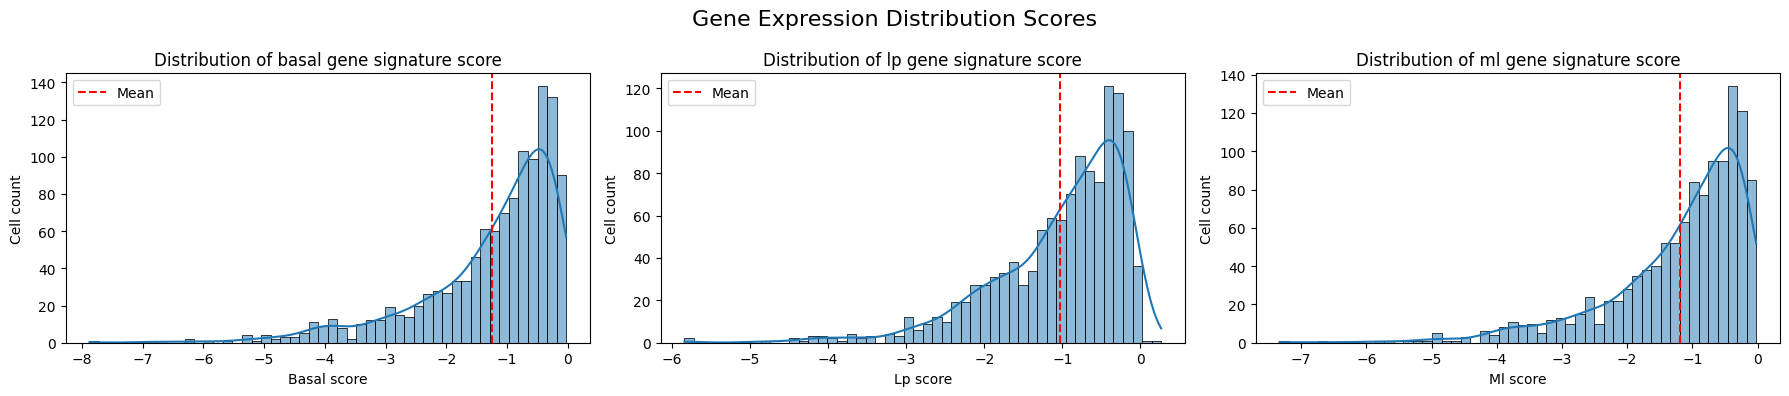

In [18]:
adata = score_gene_signature_expression(filenames[0])
show_gene_signature_scores(adata)

The negative score says that the relative expression of these signatures is centerd around a mean of zero, which directly contradicts the findings in the paper. Given the right skewedness of the distributions, look at the distribution of the data to see if it needs to be log-normalized.

In [7]:
adata.obs['total_counts'].describe()

count     1198.000000
mean      6474.341309
std       5706.500488
min        503.000000
25%       2399.750000
50%       4753.000000
75%       8662.500000
max      39818.000000
Name: total_counts, dtype: float64

These values indicate that the counts are **not** log-normalized, let's do that next.

#### 1.1.2. Log normalize data before scoring

Log normalizing dataset...


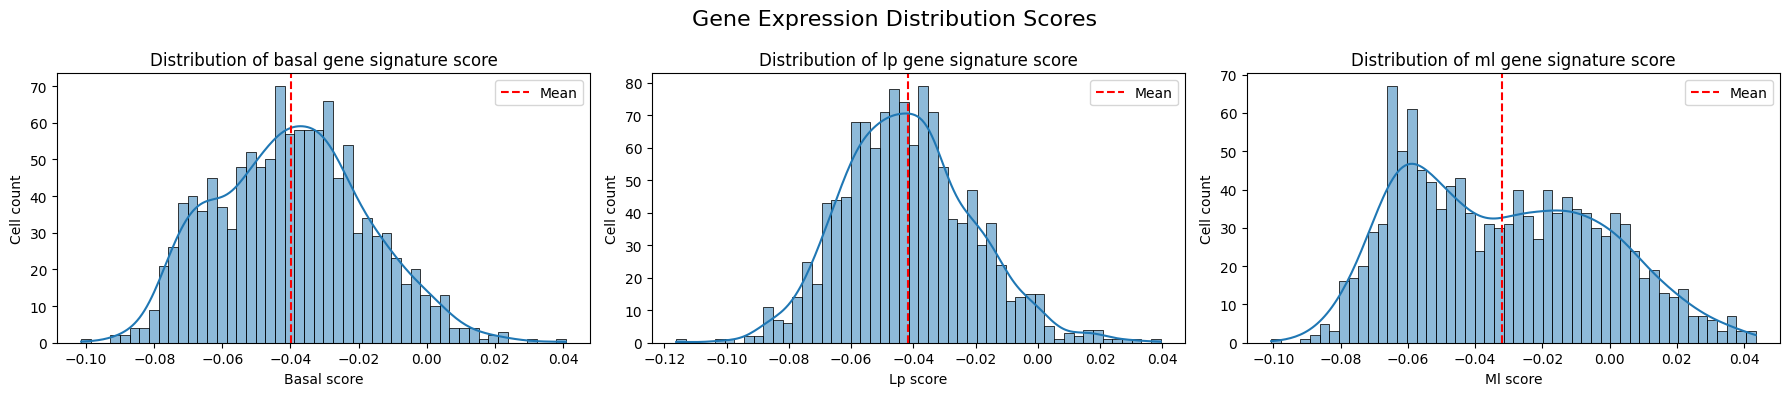

In [19]:
adata = score_gene_signature_expression(filenames[0], log_normalize=True)
show_gene_signature_scores(adata)

#### 1.1.3. Log normalize data and filtered for highly variable genes before scoring

One important note about the [format of the data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE161529) shared by the authors. All the datasets share a single features file. In other words, the features (e.g. genes) listed in the single features file consists of all the unique features (genes) in the entire dataset (69 datasets). This results in every dataset having **33,538** features (e.g. genes, columns), where most of the expression values are zero or close to zero.

In [9]:
gse.get_dataset(filenames[0]).shape

(1198, 33538)

It's recommended that single-cell RNA sequencing data be filtered down to highly variable genes to more effectively use dimensionality reduction and improve signal detection.

Log normalizing dataset...
Filtering dataset to highly variable genes...


C:\Users\silly\GitHub\signals-in-the-noise\.venv\Lib\site-packages\scanpy\tools\_score_genes.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


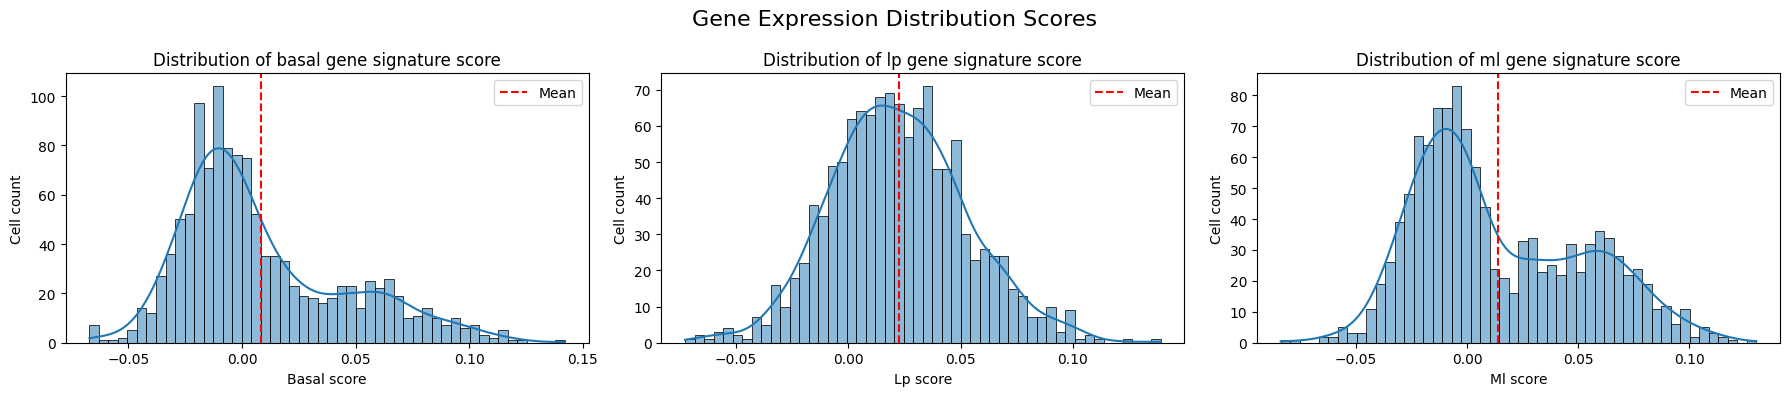

In [20]:
adata = score_gene_signature_expression(filenames[0], log_normalize=True, hvg_only=True)
show_gene_signature_scores(adata)

### 1.2. Predict cell types

Using the scoring defined in `1.1.3.`, now predict what population (type) the cell belongs to by seeing which of the 3 populations it scores the highest on. As we are expecting upregulation, if the highest value is negative, the cell will be typed as "Other".

In [15]:
adata = score_gene_signature_expression(filenames[0], log_normalize=True, hvg_only=True)

Log normalizing dataset...
Filtering dataset to highly variable genes...


C:\Users\silly\GitHub\signals-in-the-noise\.venv\Lib\site-packages\scanpy\tools\_score_genes.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


#### 1.2.1. Identify the highest value

In [28]:
score_cols = [f"score_{k}" for k in gene_signature_filenames.keys()]
adata.obs['predicted_type'] = adata.obs[score_cols].idxmax(axis=1).str.replace('score_', '')
adata.obs['predicted_type_score'] = adata.obs[score_cols].max(axis=1)

#### 1.2.2. Check for negative highest values
If there are any negative (or zero) highest values, replace the predicted type with "Other".

In [29]:
adata.obs['predicted_type_score'].describe()

count    1198.000000
mean        0.048388
std         0.029248
min        -0.053431
25%         0.028143
50%         0.048754
75%         0.068322
max         0.142213
Name: predicted_type_score, dtype: float64

In [33]:
adata.obs.loc[adata.obs['predicted_type_score'] <= 0, 'predicted_type'] = "Other"

#### 1.2.3. Visualize predictions

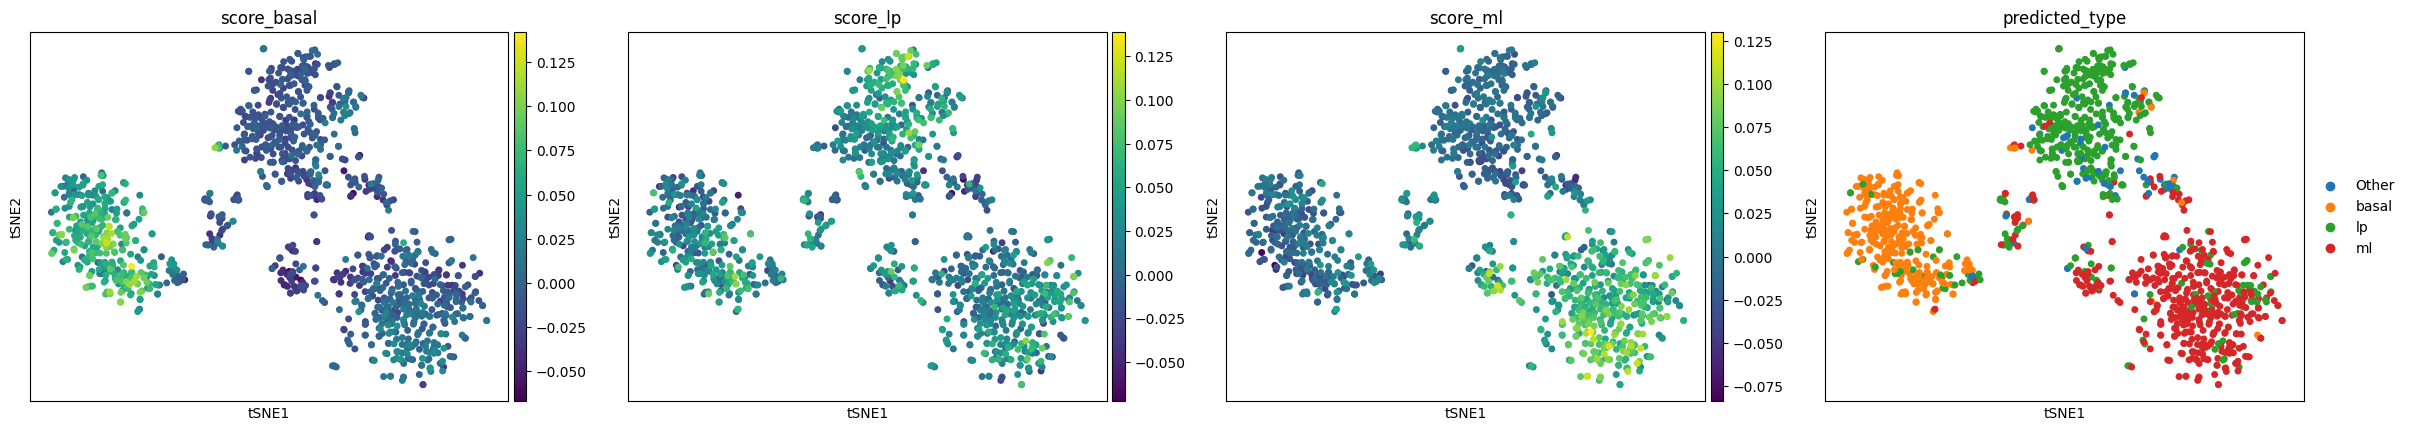

In [35]:
sc.pp.neighbors(adata)
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['score_basal', 'score_lp', 'score_ml', 'predicted_type'])

### 1.3. Run differential expression (DE) between predicted groups



In [50]:
df = sc.get.rank_genes_groups_df(adata, group=None)
filtered_df = df[(df['logfoldchanges'] > 0 ) & (df['pvals_adj'] < 0.05)]

In [52]:
marker_dict = {
    group: set(filtered_df[filtered_df['group'] == group]['names'])
    for group in adata.obs['predicted_type'].unique()
}

In [61]:
adata.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 516812 stored elements and shape (1198, 4129)>

In [70]:
# Make a DataFrame with gene names as columns
expr_df = pd.DataFrame(adata.X.toarray(), columns=adata.var_names, index=adata.obs_names)

# Step 4: Create per-group indicator columns
group_columns = []

# Only use valid genes in the expression matrix
valid_genes = set(adata.var_names)
for group, markers in marker_dict.items():
    # Filter marker genes to valid ones
    markers = list(valid_genes.intersection(markers))
    if not markers:
        continue
    colname = f"has_marker_{group}"
    group_columns.append(colname)
    adata.obs[colname] = 0

    for cell in adata.obs_names:
        if adata.obs.loc[cell, 'predicted_type'] != group:
            continue
        # Check if any marker gene is expressed
        if expr_df.loc[cell, markers].gt(0).any():
            adata.obs.at[cell, colname] = 1

# Step 5: Create 'none of the three' indicator
# It's 1 if all the individual group indicators are 0
adata.obs['has_marker_none_of_three'] = (
    (adata.obs[group_columns].sum(axis=1) == 0).astype(int)
)

In [63]:
adata

AnnData object with n_obs × n_vars = 1198 × 4129
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'is_low_num_genes', 'is_high_num_genes', 'is_high_mito', 'is_high_total_count', 'zero_genes', 'zero_mito', 'zero_count', 'is_noise', 'score_basal', 'score_lp', 'score_ml', 'predicted_type', 'predicted_type_score', 'has_marker_ml', 'has_marker_lp', 'has_marker_Other', 'has_marker_basal', 'has_marker_none_of_three'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'adata-filename', 'cancer_type', 'cell_population', 'gender', 'menopause_status', 'num_cells_after', 'num_cells_before', '

In [82]:
adata.obs.loc[adata.obs['has_marker_Other']==1]['predicted_type'].count()

np.int64(60)

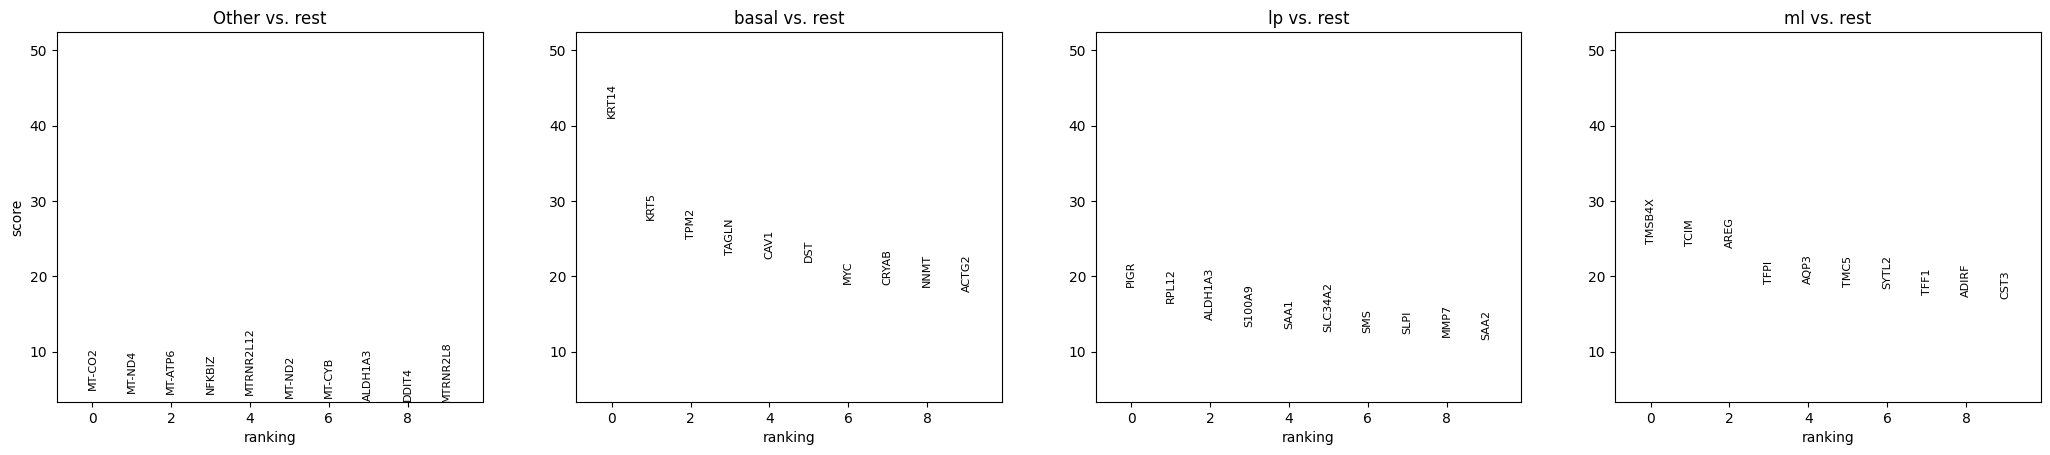

In [48]:
sc.tl.rank_genes_groups(adata, groupby='predicted_type')
sc.pl.rank_genes_groups(adata, n_genes=10)

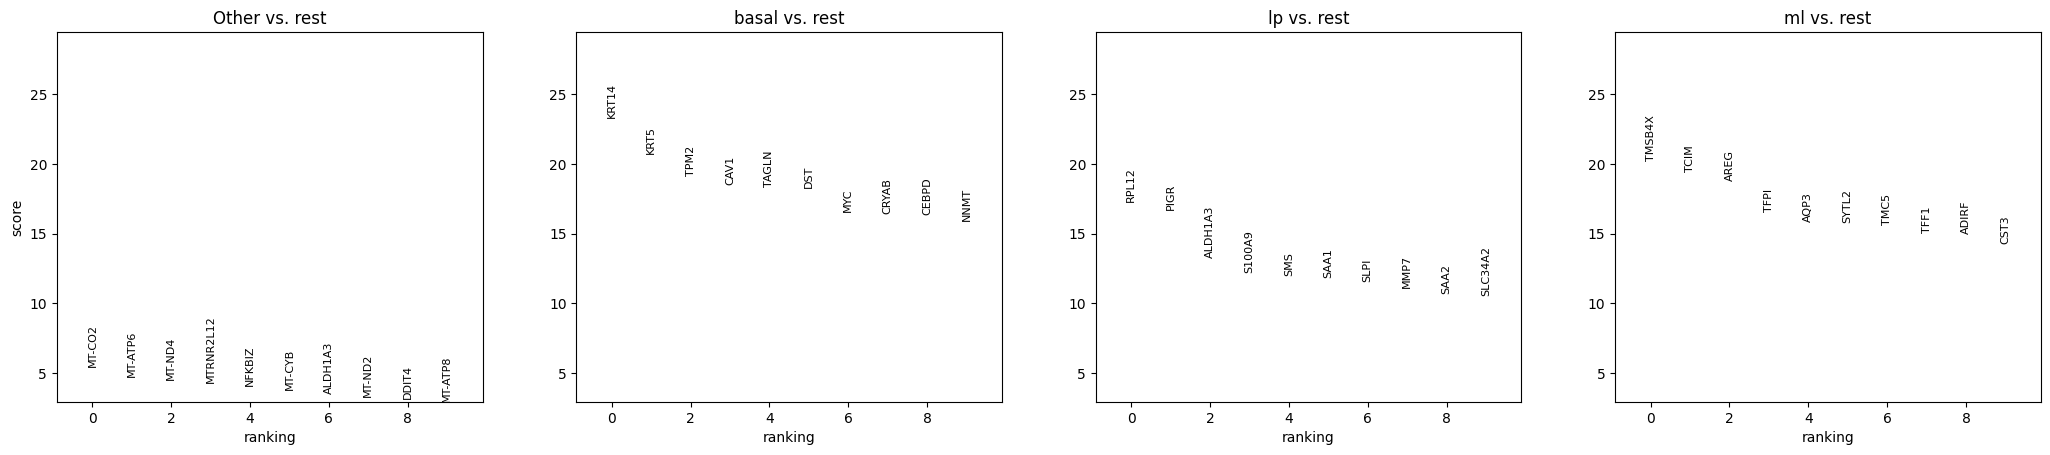

In [49]:
sc.tl.rank_genes_groups(adata, groupby='predicted_type', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10)

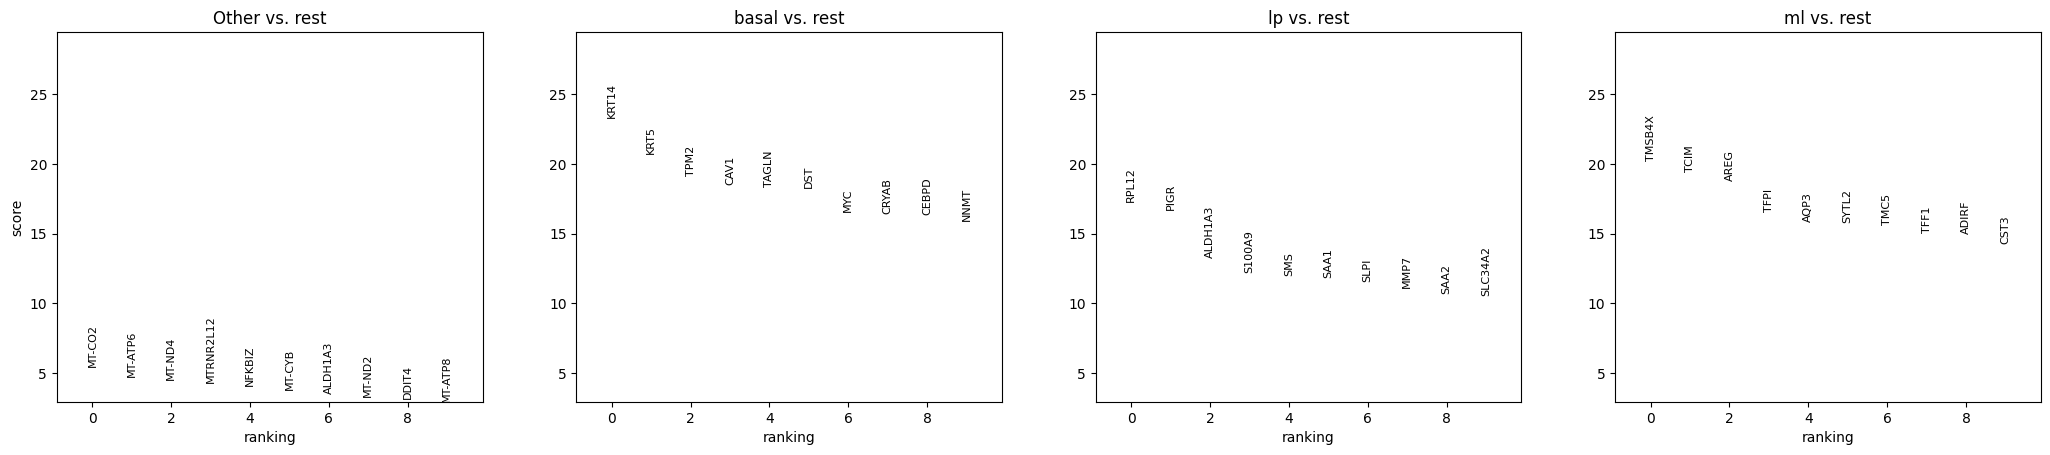

In [44]:
sc.pl.rank_genes_groups(adata, n_genes=10)